In [1]:
import librosa
import matplotlib.pyplot as plt 
import numpy

In [2]:
ai_audio_path = r"E:\Desktop\GUVI\ai\hindi\fake_12.wav"
real_audio_path = r"E:\Desktop\GUVI\real\hindi\common_voice_hi_24228332.mp3"
y_ai,sr = librosa.load(ai_audio_path,sr=16000)
y_h, _ = librosa.load(real_audio_path,sr=16000)
ai_audio_path= r"E:\Desktop\GUVI\ai\english\fake_15.wav"
real_audio_path = r"E:\Desktop\GUVI\real\hindi\common_voice_hi_25038064.mp3"

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
librosa.display.waveshow(y_ai,sr=sr)
plt.title("Ai Voice Waveform")

plt.subplot(1,2,2)
librosa.display.waveshow(y_h,sr=sr)
plt.title("Human Voice Waveform")
plt.show()

# y_ai,sr = librosa.load(ai_audio_path,sr=16000)
# y_h, _ = librosa.load(real_audio_path,sr=16000)

# plt.figure(figsize=(12,4))
# plt.subplot(1,2,1)
# librosa.display.waveshow(y_ai,sr=sr)
# plt.title("Ai Voice Waveform")

# plt.subplot(1,2,2)
# librosa.display.waveshow(y_h,sr=sr)
# plt.title("Human Voice Waveform")
# plt.show()


C:\Users\piyus\AppData\Local\Temp\ipykernel_21920\1381375490.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  y_ai,sr = librosa.load(ai_audio_path,sr=16000)
c:\Users\piyus\AppData\Local\Programs\Python\Python312\Lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


FileNotFoundError: [Errno 2] No such file or directory: 'E:\\Desktop\\GUVI\\ai\\hindi\\fake_12.wav'

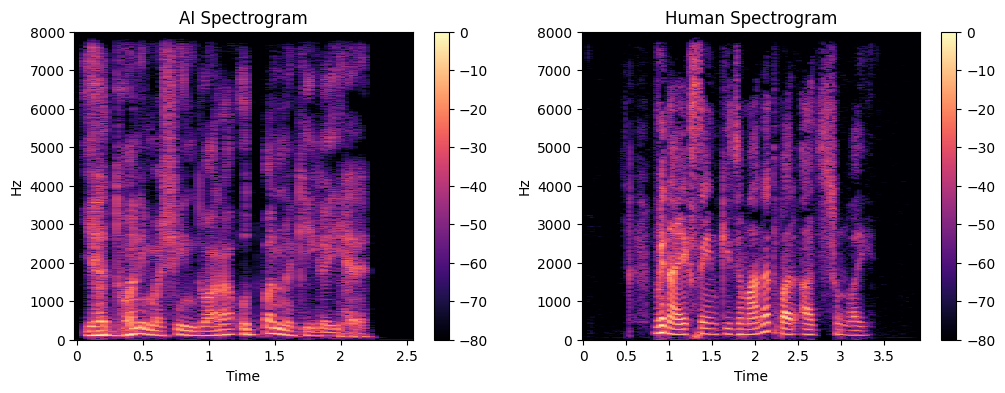

In [ ]:
import numpy as np

def plot_spectrogram(y, sr, title):
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()
    plt.title(title)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plot_spectrogram(y_ai, sr, "AI Spectrogram")

plt.subplot(1,2,2)
plot_spectrogram(y_h, sr, "Human Spectrogram")
plt.show()


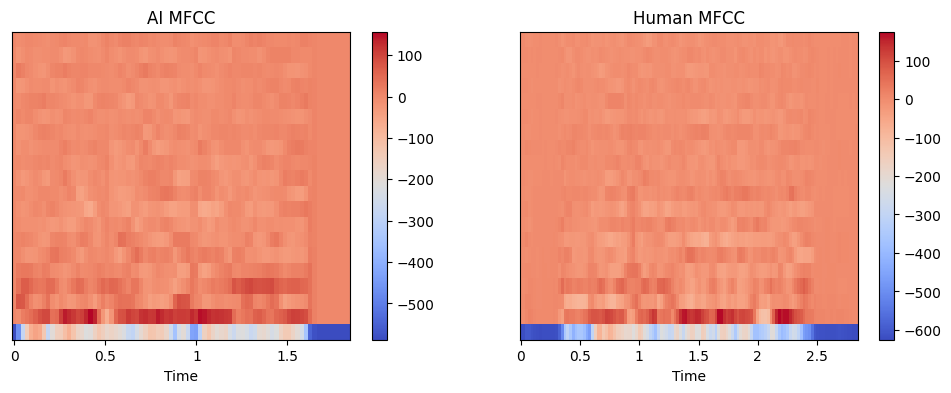

In [ ]:
mfcc_ai = librosa.feature.mfcc(y=y_ai, sr=sr, n_mfcc=20)
mfcc_h = librosa.feature.mfcc(y=y_h, sr=sr, n_mfcc=20)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
librosa.display.specshow(mfcc_ai, x_axis='time')
plt.colorbar()
plt.title("AI MFCC")

plt.subplot(1,2,2)
librosa.display.specshow(mfcc_h, x_axis='time')
plt.colorbar()
plt.title("Human MFCC")
plt.show()


In [8]:
import whisper
import torch
import librosa
import numpy as np

model = whisper.load_model("base")

def wav_to_vector(path, sr=16000):
    # Load mp3 safely WITHOUT ffmpeg
    y, _ = librosa.load(path, sr=sr, mono=True)

    # Whisper expects ~30 sec max, pad or trim
    y = whisper.pad_or_trim(y)

    # Convert to log-mel
    mel = whisper.log_mel_spectrogram(y).to(model.device)

    with torch.no_grad():
        emb = model.encoder(mel.unsqueeze(0))

    # Fixed-length vector
    return emb.mean(dim=1).cpu().numpy().flatten()

In [10]:
import os
import pandas as pd

def build_metadata_dataframe(base_dir="../dataset"):
    rows = []

    for label_name, label in [("ai", 1), ("real", 0)]:
        label_path = os.path.join(base_dir, label_name)

        for language in os.listdir(label_path):
            lang_path = os.path.join(label_path, language)
            if not os.path.isdir(lang_path):
                continue

            for file in os.listdir(lang_path):
                rows.append({
                    "path": os.path.join(lang_path, file),
                    "language": language,
                    "label": label
                })

    return pd.DataFrame(rows)

df = build_metadata_dataframe("../dataset")
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
print(df.head())
print(df["label"].value_counts())


                                                path   language  label
0  ../dataset\real\malayalam\common_voice_ml_3226...  malayalam      0
1  ../dataset\real\telugu\common_voice_te_4159251...     telugu      0
2                ../dataset\ai\malayalam\fake_76.wav  malayalam      1
3  ../dataset\real\telugu\common_voice_te_4009553...     telugu      0
4                    ../dataset\ai\hindi\fake_78.wav      hindi      1
label
1    496
0    339
Name: count, dtype: int64


In [11]:
df.to_csv("audio_metadata.csv", index=False)


In [12]:
from tqdm import tqdm
x = []
y= []
for _, row in tqdm(df.iterrows(), total=len(df)):
    vec = wav_to_vector(row["path"])
    x.append(vec)
    y.append(row["label"])

X = np.array(x)   # shape: (N, 768)
y = np.array(y)   # shape: (N,)


100%|██████████| 835/835 [17:41<00:00,  1.27s/it]


In [13]:
np.save("X_embeddings.npy", X)
np.save("y_labels.npy", y)


In [14]:
from sklearn.model_selection import train_test_split

X_train,X_test, y_train, y_test =  train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

svm_model = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(
        kernel="rbf",
        C=10,
        gamma="scale",
        probability=True,
        class_weight="balanced"
    ))
])

svm_model.fit(X_train, y_train)

,steps,"[('scaler', ...), ('svm', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,C,10
,kernel,'rbf'
,degree,3
,gamma,'scale'


In [16]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred = svm_model.predict(X_test)
y_prob = svm_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))


              precision    recall  f1-score   support

           0       1.00      0.99      0.99        68
           1       0.99      1.00      0.99        99

    accuracy                           0.99       167
   macro avg       0.99      0.99      0.99       167
weighted avg       0.99      0.99      0.99       167

ROC-AUC: 1.0


In [17]:
import joblib

joblib.dump(svm_model, "whisper_svm_ai_vs_human.pkl")


['whisper_svm_ai_vs_human.pkl']